In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/img_final.zip'

-rw------- 1 root root 51735135 Apr 19 02:51 '/content/drive/My Drive/Colab Notebooks/datasets/img_final.zip'


In [4]:
!unzip '/content/drive/My Drive/Colab Notebooks/datasets/img_final.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/img_final.zip
  inflating: img/0/001.jpg           
  inflating: img/0/002.jpg           
  inflating: img/0/003.jpg           
  inflating: img/0/004.jpg           
  inflating: img/0/005.jpg           
  inflating: img/0/006.jpg           
  inflating: img/0/007.jpg           
  inflating: img/0/008.jpg           
  inflating: img/0/009.jpg           
  inflating: img/0/010.jpg           
  inflating: img/0/011.jpg           
  inflating: img/0/012.jpg           
  inflating: img/0/013.jpg           
  inflating: img/0/014.jpg           
  inflating: img/0/015.jpg           
 extracting: img/0/016.jpg           
 extracting: img/0/017.jpg           
 extracting: img/0/018.jpg           
 extracting: img/0/019.jpg           
 extracting: img/0/020.jpg           
  inflating: img/0/021.jpg           
  inflating: img/0/022.jpg           
  inflating: img/0/023.jpg           
  inflating: img/0/024.jpg           
  inflating: im

In [9]:
import pathlib
from glob import glob
from keras.preprocessing import image
import os

In [10]:
!ls -l ./img

total 24
drwxr-xr-x 2 root root 12288 Apr 19 02:55 0
drwxr-xr-x 2 root root 12288 Apr 19 02:55 1


In [19]:
# Made folder to seperate images
os.mkdir('/content/drive/MyDrive/best')  # 정확한 폴더 생성 경로 지정
os.mkdir('/content/drive/MyDrive/worst')

In [25]:
data_root = pathlib.Path(glob('/content/drive/MyDrive/best')[0])
print(data_root)
# label = ['0','1']

/content/drive/MyDrive/best


In [26]:
# data_root = pathlib.Path(glob('/content/drive/MyDrive/best')[0])
# print(data_root)
# # label = ['0','1']

all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]

for img_path in all_image_paths:
    img = image.load_img(img_path)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    print(img_path)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # 해당 경로의 이미지를

    # numpy array 로 변경해서 출력
    #print(x)

#print(len(x))


In [28]:
from keras.preprocessing.image import ImageDataGenerator

# image directory
image_dir = '/content/img'

random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 10, class_mode = 'binary', subset='training')
valid_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=10, class_mode='binary', subset='validation')


Found 382 images belonging to 2 classes.
Found 162 images belonging to 2 classes.


In [29]:
from tensorflow.keras.applications import ResNet50

conv_base =  ResNet50(weights='imagenet', include_top=False, input_shape =(640,640,3))

set_trainable = False

for layer in conv_base.layers:
    if layer.name =='conv5_block3_2_conv' :      
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 646, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 320, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1_conv[0][0]                 
__________________________

In [31]:
from keras import layers, models, optimizers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.000005), metrics=['accuracy'])    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 20, 20, 2048)      23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 819200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               209715456 
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 233,303,425
Trainable params: 213,131,265
Non-trainable params: 20,172,160
_________________________________________________________________


In [32]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
session = InteractiveSession(config = config)

In [33]:
%%time

Hist = model.fit(train_generator, steps_per_epoch=38,
                epochs=50, validation_data=valid_generator, validation_steps=16) 

Epoch 1/50
38/38 [==============================] - 53s 458ms/step - loss: 1.1976 - accuracy: 0.5693 - val_loss: 0.9455 - val_accuracy: 0.5063
Epoch 2/50
38/38 [==============================] - 16s 410ms/step - loss: 0.6230 - accuracy: 0.6565 - val_loss: 0.7698 - val_accuracy: 0.5063
Epoch 3/50
38/38 [==============================] - 16s 414ms/step - loss: 0.5058 - accuracy: 0.7502 - val_loss: 0.6500 - val_accuracy: 0.5750
Epoch 4/50
38/38 [==============================] - 16s 421ms/step - loss: 0.4325 - accuracy: 0.7772 - val_loss: 0.5957 - val_accuracy: 0.6875
Epoch 5/50
38/38 [==============================] - 16s 420ms/step - loss: 0.3552 - accuracy: 0.8547 - val_loss: 0.6110 - val_accuracy: 0.6687
Epoch 6/50
38/38 [==============================] - 16s 423ms/step - loss: 0.3460 - accuracy: 0.8510 - val_loss: 0.5578 - val_accuracy: 0.7000
Epoch 7/50
38/38 [==============================] - 16s 427ms/step - loss: 0.2813 - accuracy: 0.9066 - val_loss: 0.5362 - val_accuracy: 0.7312

In [34]:
loss, accuracy = model.evaluate(valid_generator, steps=5)
loss, accuracy

5/5 [==============================] - 1s 276ms/step - loss: 0.5539 - accuracy: 0.8800


(0.5538997650146484, 0.8799999952316284)

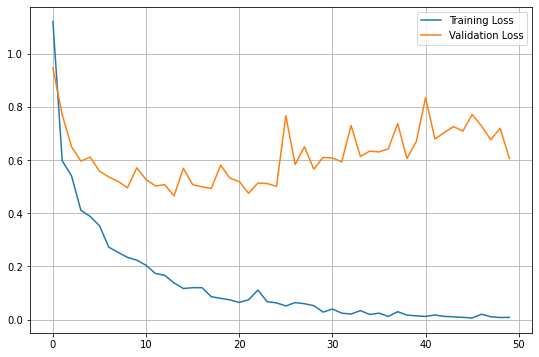

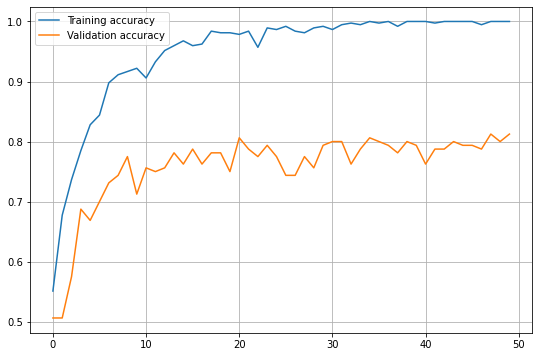

In [35]:
import matplotlib.pyplot as plt


plt.figure(figsize = (9, 6))
plt.plot( Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot( Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()